# Deep Reinforcement Learning Assignment

This assignment should be done in groups of 2 or 3 (preferably 3).

This assignment consists of two parts. In the first part, your task is to solve a grid world environment using the REINFORCE algorithm. In the second part, your task is to balance a pendulum attached to a cart such that it stays upright. You will implement the A2C algorithm that will learn a control policy for the cart.

## Imports
Imports required packages. Add additional packages if needed.

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 15.3 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np

import torch

import tqdm

import matplotlib.pyplot as plt
from matplotlib.table import Table

# Part 1: GridWorld with REINFORCE (9 pts)
Firstly, you will implement REINFORCE in the GridWorld environment. The agent starts from the center, and the four actions left, right, up and down move the agent in the appropriate directions deterministically. The corner states are terminal and have the corresponding rewards.

**In this part, you should only use `numpy` operations (i.e., no automated differentiation with PyTorch).**

### The GridWorld Environment

We already provide a basic implementation of the grid world environment which you will use,
as well as the constants `ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN`.
You do not need to modify the class `GridWorld`.

In [2]:
#DO NOT MOIFY
ACTION_LEFT = 0
ACTION_RIGHT = 1
ACTION_UP = 2
ACTION_DOWN = 3

def clip(x, a, b):
    if x < a:
        return a
    if x > b:
        return b

    return x

class GridWorld:

    def __init__(self, size=3):
        self.size = size
        self.state = [0,0]
        self.actions = [ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN]

    def reset_world(self):
        self.state = [0,0]

    def is_terminal(self):
        return abs(self.state[0]) == self.size and abs(self.state[1]) == self.size

    def get_current_reward(self):
        if self.state == [self.size, self.size] or \
           self.state == [-self.size, -self.size]:
            return -1
        elif self.state == [-self.size, self.size] or \
             self.state == [self.size, -self.size]:
            return +1
        else:
            return 0

    def list_actions(self):
        return self.actions

    def step(self, action):
        if action not in self.actions:
            raise NotImplementedError("Action not defined")

        if self.is_terminal():
            raise NotImplementedError("Epsiode terminated! Call reset_world first.")

        if action == ACTION_LEFT:
            self.state[0] = clip(self.state[0]-1, -self.size, self.size)

        elif action == ACTION_RIGHT:
            self.state[0] = clip(self.state[0]+1, -self.size, self.size)

        elif action == ACTION_UP:
            self.state[1] = clip(self.state[1]+1, -self.size, self.size)

        elif action == ACTION_DOWN:
            self.state[1] = clip(self.state[1]-1, -self.size, self.size)

    def get_coordinates(self):
        s = np.array(self.state)
        s[0] = s[0] + self.size
        s[1] = self.size - s[1]

        return s

    def get_state(self):
        return self.get_coordinates()[0] + \
               self.get_coordinates()[1] * (self.size * 2 + 1)

    def render_state(self):
        N = self.size
        x = self.state[0]
        y = self.state[1]

        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_axis_off()

        tb = Table(ax, bbox=[0,0, 1, 1])

        row_labels = np.arange(2 * N + 1)
        col_labels = np.arange(2 * N + 1)
        width, height = .5, .5

        values = np.zeros((N*2+1, N*2+1))
        values[0,0] = values[-1, -1] = 1
        values[-1,0] = values[0, -1] = -1

        cell_colors = ('white', 'whitesmoke')
        font_colors = ('black', 'white')

        for (row_idx, col_idx), cell_val in np.ndenumerate(values):
            idx = (col_idx + row_idx) % 2
            if cell_val !=  0.:
                text = "%.1f" % cell_val
                if cell_val > 0:
                    c = "lightblue"
                else:
                    c = "lightcoral"
            elif row_idx == N and col_idx == N:
                text = "start"
                c = "antiquewhite"
            else:
                text = ""
                c = cell_colors[idx]

            tb.add_cell(row_idx, col_idx, width, height,
                        text=text,
                        loc='center',
                        facecolor=c)

        for (row_idx, col_idx), cell_val in np.ndenumerate(values):
            idx = (col_idx + row_idx) % 2
            tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[idx])

        pos = plt.Circle((0.5 + 1/(2 * N + 1) * x, 0.5 + 1/(2 * N + 1) * y + .04), 0.01, color='black')
        ax.add_patch(pos)
        ax.add_table(tb)

You can plot the environment with `render_state()`

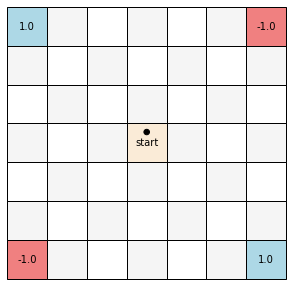

In [3]:
GridWorld().render_state()

The state after the agent takes the action `ACTION_RIGHT`

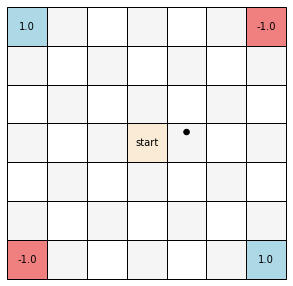

In [4]:
world = GridWorld()
world.reset_world()
world.step(ACTION_RIGHT)
world.render_state()

Cells/states are numbered from 0 to 48, left to right, top to bottom

In [5]:
world.get_state()

25

For convenience, cells are given coordinates left to right, top to bottom

In [6]:
world.get_coordinates()

array([4, 3])

### Direct Parameterization

In this part, we will define the policy according to an exponential softmax distribution where action preferences are linear using feature vectors \phi_{s,a}:
$$
\pi_\theta(a|s) = \frac{\exp{\theta^\top \phi_{s,a}}}{\sum_{a'} {\exp{\theta^\top \phi_{s,a'}}}}
$$

We will assume that the vectors $\phi_{s,a} \in \mathbb{R}^{|\mathcal{S}||\mathcal{A}|}$ are encoded as standard unit basis vectors (i.e., one-hot encoding).
First, we will create an appropriate encoding function for the states in GridWorld.

For consistency, we assume the actions are mapped to integers with `ACTION_LEFT=0, ACTION_RIGHT=1, ACTION_UP=2, ACTION_DOWN=3`, and the cell states are given values from 0 to 48, starting from left to right, from the top row to the bottom row.
Note that `GridWorld.get_state()` implements the correct order on grid cells.
$\phi_{s,a}$ is assumed to be the unit vector with only the entry at position $4\times s + a$ equal to 1.





**Task 1.1 (0.5 pt):** Create a function `get_features_onehot` that encodes each $\phi_{s,a}$ with a one hot encoded vector in $\mathbb{R}^{|\mathcal{S}||\mathcal{A}|} = \mathbb{R}^{196}$ as a numpy vector.

In [7]:
def get_features_onehot(state:int, action:int):
    """Given the tuple (x,y) indicating the coordinates on the grid world, return one hot encoded features

    Assume actions are numbered from 0 to 3, and states are numbered from 0 to 48
    as explained above.
    """

    # TODO: FILL IN YOUR CODE HERE!
    feature_vector = np.zeros(196)
    feature_vector[4 * state + action] = 1

    pass

**Task 1.2 (0.5 pt):** Implement an initialisation for the parameters $\theta \in \mathbb{R}^{196}$ as a numpy vector that you think is appropriate for efficient exploration.

In [8]:
def get_initial_parameters():
    """Returns vector of size 196 of initial parameters theta"""
    theta = np.random.uniform(-0.1, 0.1, size=196)
    return theta


**Task 1.3 (2 pts):**
Calculate the partial derivatives $\frac{\partial \pi_\theta(a|s)}{\partial \theta}$.
First, write down the analytic formula for the derivative *in the Markdown cell below (use LaTeX-math mode for equations, etc.).* Show your computation steps!


Then, using your expression fill in `direct_parameterisation_derivative`, that will return the vector $\frac{\partial \pi_\theta(a|s)}{\partial \theta}$ given a value of $\theta$ and action-state pair $a,s$.

**Hint:** For the analytic part, you may write down the formula for $\frac{\partial \pi_\theta(a|s)}{\partial \theta_{a',s'}}$, i.e., the partial derivative with respect to the entry of $\theta$ corresponding to any action-state pair $a', s'$.

**Hint:** The function `direct_parameterisation_derivative` should return a vector of size $4 |S| = 4 \times 7^2=196$, since you have 4 actions and $7^2$ states.

**Hint:** Only 4 entries of $\frac{\partial \pi_\theta(a|s)}{\partial \theta} \in \mathbb{R}^{196}$ should be nonzero for fixed $a,s$.

# Analytic Derivation of $\frac{\partial \pi_{\theta}(a \mid s)}{\partial \theta}$

The policy is defined as:

$$
\pi_{\theta}(a \mid s) = \frac{\exp(\theta^\top \phi_{s,a})}{\sum_{a'} \exp(\theta^\top \phi_{s,a'})}
$$

Since the feature vectors $\phi_{s,a}$ are one-hot encoded unit vectors, $\theta^\top \phi_{s,a}$ simplifies to:

$$
\theta^\top \phi_{s,a} = \theta_{s,a}
$$

where $\theta_{s,a}$ is the component of $\theta$ corresponding to state $s$ and action $a$.

Now, compute the derivative of $\pi_{\theta}(a \mid s)$ with respect to $\theta_{s',a'}$:

- When $s' \neq s$, $\pi_{\theta}(a \mid s)$ does not depend on $\theta_{s',a'}$ (since the policy for state $s$ depends only on $\theta$ parameters corresponding to $s$), so:

$$
\frac{\partial \pi_{\theta}(a \mid s)}{\partial \theta_{s',a'}} = 0 \quad \text{for} \quad s' \neq s
$$

- When $s' = s$, we have:

$$
\frac{\partial \pi_{\theta}(a \mid s)}{\partial \theta_{s,a'}} = \frac{\partial}{\partial \theta_{s,a'}} \left( \frac{\exp(\theta_{s,a})}{\sum_{a''} \exp(\theta_{s,a''})} \right)
$$

Let $Z(s) = \sum_{a''} \exp(\theta_{s,a''})$. Then:

$$
\frac{\partial \pi_{\theta}(a \mid s)}{\partial \theta_{s,a'}} = \frac{\exp(\theta_{s,a})}{Z(s)} \left( \delta_{a,a'} - \pi_{\theta}(a' \mid s) \right)
$$

Simplifying further using $\pi_{\theta}(a \mid s) = \frac{\exp(\theta_{s,a})}{Z(s)}$:

$$
\frac{\partial \pi_{\theta}(a \mid s)}{\partial \theta_{s,a'}} = \pi_{\theta}(a \mid s) \left( \delta_{a,a'} - \pi_{\theta}(a' \mid s) \right)
$$

where $\delta_{a,a'}$ is the Kronecker delta function, which is 1 if $a = a'$ and 0 otherwise.

Thus, the final expression is:

$$
\frac{\partial \pi_{\theta}(a \mid s)}{\partial \theta_{s,a'}} =
\begin{cases}
\pi_{\theta}(a \mid s)(1 - \pi_{\theta}(a \mid s)) & \text{if } a' = a \\
-\pi_{\theta}(a \mid s) \pi_{\theta}(a' \mid s) & \text{if } a' \neq a
\end{cases}
$$


In [5]:
def direct_parameterisation_gradient(action: int, state: int, theta: np.ndarray):
    """Returns the partial derivatives of the policy with respect to theta.

    Args:
        action (int): The action taken in the current state (0 to 3).
        state (int): The current state index (0 to 48).
        theta (np.ndarray): The parameter vector of size 196.

    Returns:
        np.ndarray: The gradient vector of size 196.
    """
    # Initialize gradient vector with zeros
    grad = np.zeros_like(theta)  # Size 196

    # Indices for the current state's parameters in theta
    idx_start = 4 * state
    idx_end = idx_start + 4

    # Extract theta values for the current state s
    theta_s = theta[idx_start:idx_end]  # Shape (4,)

    # Compute the exponentials exp(θ_{s,a})
    exp_theta_s = np.exp(theta_s)

    # Compute the partition function Z(s)
    Z_s = np.sum(exp_theta_s)

    # Compute policy probabilities πθ(a'|s) for all actions
    pi_s = exp_theta_s / Z_s  # Shape (4,)

    # Policy probability for the taken action
    pi_a_s = pi_s[action]

    # Compute the gradient entries for the current state
    for a_prime in range(4):
        idx = idx_start + a_prime  # Index in theta and grad
        if a_prime == action:
            # For the taken action
            grad[idx] = pi_a_s * (1 - pi_s[a_prime])
        else:
            # For other actions
            grad[idx] = -pi_a_s * pi_s[a_prime]

    return grad


The code below helps you check if your derivative implementation is correct.
In case your implementation works, the code should print success.
You should not modify the cell below.

In [12]:
# DO NOT MODIFY
# checks the code above
torch.manual_seed(0)
success = True
N = 10
err = 0.

for i in range(N):
    theta = torch.rand((4*49))
    theta.requires_grad = True

    for state in range(49):
        for action in range(4):
            by_state = torch.exp(theta).reshape(49,4)
            out_prob = by_state / by_state.sum(-1, keepdim=True)
            out_prob.reshape(-1)[action + state*4].backward()

            answer = direct_parameterisation_gradient(action, state, theta.detach().cpu().numpy())

            err += np.abs(answer - theta.grad.cpu().numpy()).sum()

            if not np.allclose(answer, theta.grad.cpu().numpy()):
                success = False

            theta.grad.zero_()

if success:
    print(f"Success: errors within tolerance. Mean abs. error: {err / (4 * 49 * N)}")
else:
    print(f"Fail: errors not within tolerance. Mean abs. error: {err / (4 * 49 * N)}")

del theta, by_state, out_prob, answer

Success: errors within tolerance. Mean abs. error: 2.5945886665461015e-08


### REINFORCE Implementation

**Task 1.4 (0.5 pt):** In the lectures, you have been introduced to the REINFORCE algorithm. Explain in a few sentences what the regular REINFORCE objective aims to optimise and how it is achieved only using sample and no prior information on the MDP dynamics.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

# Explanation of the REINFORCE Objective

The REINFORCE algorithm aims to maximize the expected cumulative reward (also known as the return) by adjusting the policy parameters in the direction that increases the likelihood of taking actions that lead to higher rewards. Specifically, it optimizes the objective function:

$$
J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}} \left[ G(\tau) \right]
$$

where:

- $\theta$ are the policy parameters,
- $\tau$ represents a trajectory (sequence of states and actions),
- $G(\tau)$ is the cumulative reward of the trajectory,
- $\pi_{\theta}$ is the policy parameterized by $\theta$.

REINFORCE achieves this optimization using only sampled trajectories without prior knowledge of the MDP dynamics (transition probabilities and reward functions). It does so by estimating the gradient of the expected return with respect to the policy parameters using Monte Carlo methods:

$$
\nabla_{\theta} J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=0}^{T_i} \nabla_{\theta} \log \pi_{\theta}(a_t^i \mid s_t^i) G_t^i
$$

where:

- $N$ is the number of sampled trajectories,
- $T_i$ is the length of trajectory $i$,
- $G_t^i$ is the cumulative reward from time $t$ onwards in trajectory $i$.

This gradient estimate relies solely on samples from the policy and observed rewards, allowing the agent to learn optimal behaviors without explicit knowledge of the MDP dynamics.


**Task 1.5 (3 pts):** Using your functions implemented in Task 1.1, 1.2 and 1.3, fill in the `ReinforceLearner` class. You can use the already implemented methods of the GridWorld class:
- `reset_world`: reset the world to starting state
- `is_terminal`: is the current state terminal
- `get_current_reward`: reward of the current state
- `step`: given an action among `ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN`, takes a step in the simulation
- `get_state`: get current state, as an integer from 0 to 48
- `get_coordinates`: get current coordinates in table as a tuple (x,y)
- `render_state`: render the current state of the grid world, useful for debugging

**Hint:** You do not need to implement an exploration strategy with the appropriate intialisation, so only vanilla policy gradient steps should be sufficient for convergence with an appropriate learning rate.

In [13]:
class ReinforceLearner:

    def __init__(self, learning_rate, gamma):
        """Initialization code"""
        self.world = GridWorld()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.theta = get_initial_parameters()
        self.action_space = [ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN]
        self.state_space_size = (2 * self.world.size + 1) ** 2  # 49 states

    def get_action_prob(self, state:int):
        """Given the state, return the probability of taking each of the 4 actions"""
        idx_start = 4 * state
        idx_end = idx_start + 4
        theta_s = self.theta[idx_start:idx_end]  # Shape (4,)
        exp_theta_s = np.exp(theta_s - np.max(theta_s))  # Numerical stability
        probs = exp_theta_s / np.sum(exp_theta_s)
        return probs

    def train(self, n_updates:int, n_trajectories:int):
        """Run the training procedure for n_updates steps"""
        rewards = []
        for episode in range(n_updates):
            avg_reward = self.reinforce_step(n_trajectories)
            rewards.append(avg_reward)
            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}/{n_updates}, Average Reward: {avg_reward:.2f}")
        return rewards

    def reinforce_step(self, n_trajectories: int):
        """Run a single gradient step for REINFORCE (without baseline)"""
        all_episode_rewards = []
        all_gradients = []

        for trajectory in range(n_trajectories):
            # Initialize lists to store states, actions, rewards
            states = []
            actions = []
            rewards = []

            # Reset the environment
            self.world.reset_world()

            while not self.world.is_terminal():
                state = self.world.get_state()
                probs = self.get_action_prob(state)
                action = np.random.choice(self.action_space, p=probs)
                self.world.step(action)
                reward = self.world.get_current_reward()

                # Store the experience
                states.append(state)
                actions.append(action)
                rewards.append(reward)

            # Compute the returns (discounted cumulative rewards)
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + self.gamma * G
                returns.insert(0, G)

            # Normalize returns for variance reduction
            returns = np.array(returns)
            returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)

            # Compute gradients for each time step
            gradients = []
            for t in range(len(states)):
                state = states[t]
                action = actions[t]
                # Gradient of log policy
                probs = self.get_action_prob(state)
                grad_log_policy = np.zeros_like(self.theta)
                idx_start = 4 * state
                idx_end = idx_start + 4
                for a_prime in range(4):
                    idx = idx_start + a_prime
                    if a_prime == action:
                        grad_log_policy[idx] = 1 - probs[a_prime]
                    else:
                        grad_log_policy[idx] = -probs[a_prime]
                # Scale by return
                grad = returns[t] * grad_log_policy
                gradients.append(grad)

            # Sum the gradients for this trajectory
            total_gradient = np.sum(gradients, axis=0)
            all_gradients.append(total_gradient)
            all_episode_rewards.append(np.sum(rewards))

        # Average the gradients over all trajectories
        mean_gradient = np.mean(all_gradients, axis=0)

        # Update parameters
        self.theta += self.learning_rate * mean_gradient

        # Return the average reward for this update
        average_reward = np.mean(all_episode_rewards)
        return average_reward

    def evaluate(self, render: bool = True):
        """Evaluate current algorithm for a single episode and return."""
        self.world.reset_world()
        total_reward = 0
        state_history = []

        while True:
            state = self.world.get_state()
            state_history.append(self.world.get_coordinates())
            probs = self.get_action_prob(state)
            action = np.random.choice(self.action_space, p=probs)
            self.world.step(action)
            reward = self.world.get_current_reward()
            total_reward += reward

            if self.world.is_terminal():
                # Record the final state after reaching the terminal state
                state_history.append(self.world.get_coordinates())
                break

        print(f"Total reward from the episode: {total_reward}")

        if render:
            for coords in state_history:
                self.world.state = [coords[0] - self.world.size, self.world.size - coords[1]]
                self.world.render_state()


### Evaluation


**Task 1.6 (1 pt):** Run the above code until convergence, and evaluate your strategy at the end.
Plot the average reward observed per epoch during training.
You made need to tune your hyper-parameters. You policy should consistently visit the postive rewards to solve the environment.

In [14]:
# TODO: Run your implementation for 1.5 here.
# Remember to evaluate it at the end. Show your evalutation (including visualization of state history)!

# Hyperparameters
learning_rate = 0.05
gamma = 0.99
n_updates = 2000
n_trajectories = 50

agent = ReinforceLearner(learning_rate=learning_rate, gamma=gamma)

# Train the agent
rewards = agent.train(n_updates=n_updates, n_trajectories=n_trajectories)




Episode 100/2000, Average Reward: 0.72
Episode 200/2000, Average Reward: 0.96
Episode 300/2000, Average Reward: 0.96
Episode 400/2000, Average Reward: 0.88
Episode 500/2000, Average Reward: 1.00
Episode 600/2000, Average Reward: 0.96
Episode 700/2000, Average Reward: 1.00
Episode 800/2000, Average Reward: 1.00
Episode 900/2000, Average Reward: 0.96
Episode 1000/2000, Average Reward: 0.96
Episode 1100/2000, Average Reward: 1.00
Episode 1200/2000, Average Reward: 1.00
Episode 1300/2000, Average Reward: 1.00
Episode 1400/2000, Average Reward: 1.00
Episode 1500/2000, Average Reward: 1.00
Episode 1600/2000, Average Reward: 0.96
Episode 1700/2000, Average Reward: 1.00
Episode 1800/2000, Average Reward: 0.96
Episode 1900/2000, Average Reward: 1.00
Episode 2000/2000, Average Reward: 1.00


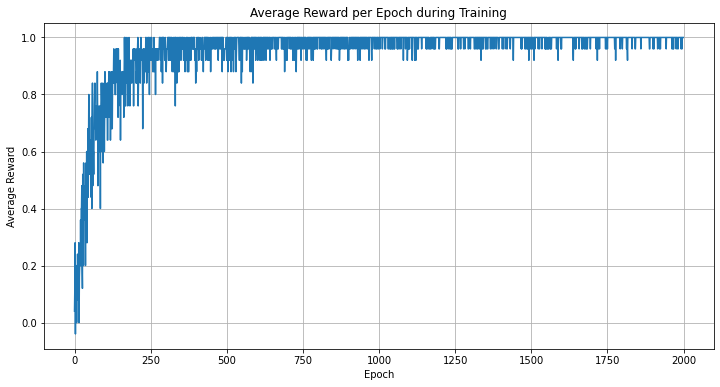

Total reward from the episode: 1


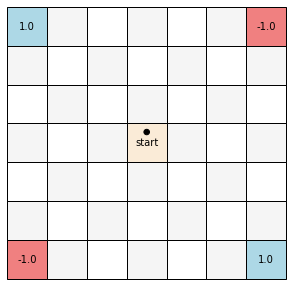

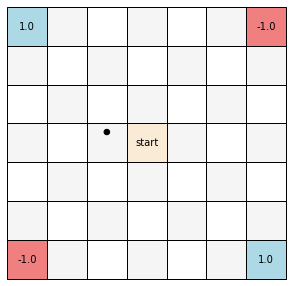

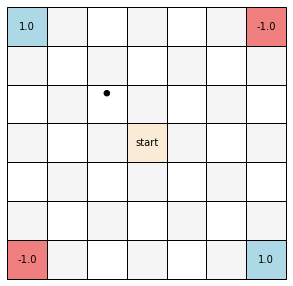

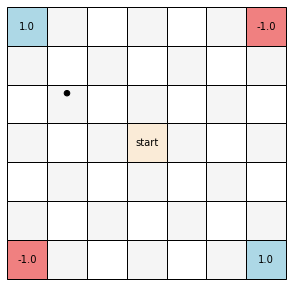

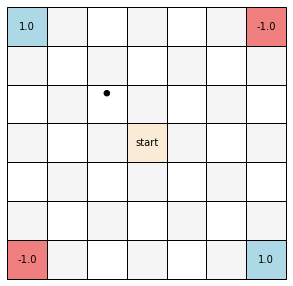

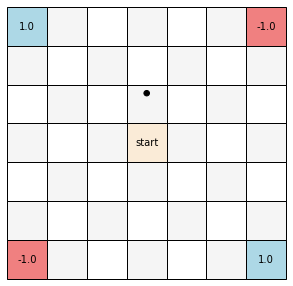

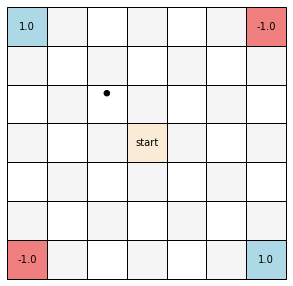

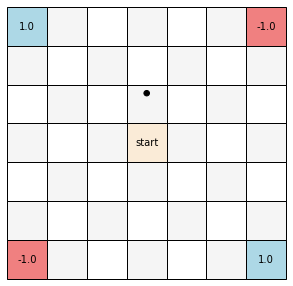

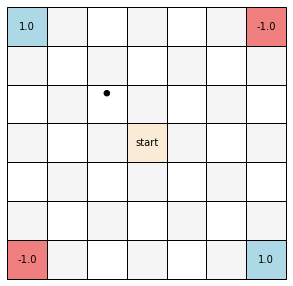

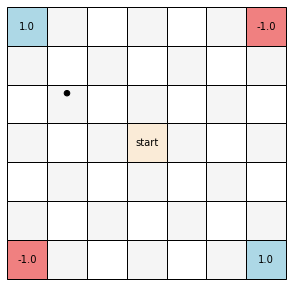

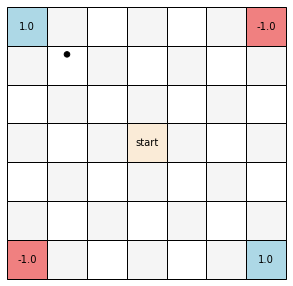

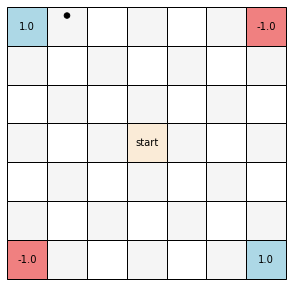

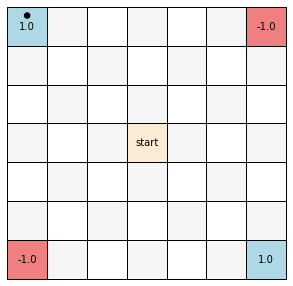

In [15]:
## TODO: Plot the average reward observed per epoch during training here
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(rewards)
plt.xlabel('Epoch')
plt.ylabel('Average Reward')
plt.title('Average Reward per Epoch during Training')
plt.grid(True)
plt.show()

# Evaluate the agent at the end of training
agent.evaluate(render=True)

### Additional Questions


**Task 1.7 (1 pt):** The code above for REINFORCE does not implement an explicit exploration strategy.
Explain how the exploration-exploitation trade-off was circumvented by your choice of parameters intialisation in a few sentences, and how this approach could fail for some initialisations.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

The exploration-exploitation trade-off in the REINFORCE implementation was implicitly managed through the initialization of the policy parameters
𝜃. By initializing 𝜃 with small random values (e.g., uniformly between
−0.1 −0.1 and 0.1 0.1), the initial policy generated by the softmax function is approximately uniform across all actions in each state. This means that the agent starts with a high degree of exploration, as each action has nearly equal probability of being selected. Over time, as the agent collects experience and updates 𝜃 based on received rewards, the policy naturally shifts towards exploiting actions that yield higher returns.

This approach can fail with certain initializations. If 𝜃 is initialized with large magnitudes or biased values, the softmax function may produce a policy that heavily favors certain actions from the start, reducing exploration. For instance, if one action's parameter is significantly higher than others due to initialization, the agent might consistently select that action and miss out on exploring potentially better alternatives. Therefore, without an explicit exploration strategy, the agent's ability to explore effectively depends on careful initialization of 𝜃, and inappropriate initial values could hinder learning by limiting exploration.



**Task 1.8 (0.5 pt):** In a few sentences explain the shortcomings of the direct parametrisation.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*


The direct parametrization has significant shortcomings due to its lack of scalability and generalization. By assigning a unique parameter to each state-action pair, it results in a parameter vector whose size grows exponentially with the number of states and actions. This makes it impractical for environments with large or continuous state spaces. Additionally, it doesn't capture similarities or shared structures between different states or actions, preventing the agent from generalizing learned behaviors to unseen situations. Consequently, learning becomes inefficient, requiring extensive data to cover all possible state-action combinations.

##  Part 2: CartPole with A2C

### The Cart Pole Environment

The [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment is a classical problem where a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

Since the focus of this task is the implementation of reinforcement
learning algorithms, it is not necessary to have a detailed understanding of the mechanics of the
Cart Pole environment beyond the observation and action space sizes.

### Initialize the environment
Initialize the Cart Pole environment in the Gymnasium library to start learning a policy for it. You can read more about the Gymnasium library [here](https://gymnasium.farama.org/).

In [20]:
env = gym.make("CartPole-v1")

### PyTorch Intro

We also introduce basic functionality for PyTorch.
PyTorch is a widely used automatic differentiation library, which is very useful for training neural networks.
This part is also for guidance and does not include questions.
While we do introduce the basics of PyTorch, you are encouraged to explore more about the library following the official [tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html) in case you haven't used it before.

PyTorch is built on top of the class `torch.Tensor`, which implements many operations on vectors, matrices and higher dimensional tensors.
The functionality of operations on torch tensors closely mirrors the operations from the `numpy` package.

In [21]:
torch.zeros(5)

tensor([0., 0., 0., 0., 0.])

In [22]:
a_matrix = [[1., 2.],[3., 4.]]
torch.tensor(a_matrix)

tensor([[1., 2.],
        [3., 4.]])

In [23]:
torch.matmul(torch.tensor(a_matrix),
             torch.tensor([4., 5.]))

tensor([14., 32.])

What makes torch special is that it implements automated differentiation by tracking the operation history on tensors.
Namely, if a `torch.Tensor` has the propery `.requires_grad` set to `True`, torch will automatically track operations made on that tensor.
A final `.backward()` call to a computation result will compute partial derivatives of the variable with respect to all tensors in the tracked computational graph.
This is particularly useful for tracking derivatives with respect to a loss function, to enable simple gradient descent.

In [24]:
# example from https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(loss)

tensor(1.0208, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [25]:
# differentiate with respect to loss
loss.backward()
# the computed partial derivatives of w
w.grad

tensor([[0.1598, 0.2628, 0.1917],
        [0.1598, 0.2628, 0.1917],
        [0.1598, 0.2628, 0.1917],
        [0.1598, 0.2628, 0.1917],
        [0.1598, 0.2628, 0.1917]])

To prevent tracking history, you can also wrap a piece of code in `with torch.no_grad():`.
This can be particularly helpful when evaluating a model on new data, when training (and hence differentiation) is not required.

For more advanced modelling (as will be required by this exercise), it is usually useful to implement classes as children of `nn.Module`.
These implement the function `forward`, which returns the output of the forward pass of a model given inputs.
Modules have `nn.Parameter`, which will be the trainable parameters of the models.
Most useful sub-modules are already provided by the torch package: see for instance `nn.Linear`.

Finally, torch implements many standard optimizers: for instance `torch.optim.SGD`, `torch.optim.Adam`.
These are typically used to automatically take care of training once partial derivatives are computed.

### Advantage Actor-Critic (A2C)

A more stable alternative to vanilla policy gradients via REINFORCE is the so-called A2C algorithm, which is a actor-critic method.
First, you should familiarise yourself with the A2C algorithm reading the original [paper](https://arxiv.org/pdf/1602.01783.pdf).

**Task 2.1 (3 pts):** Explain in a few sentences each,

1. how the A2C algorithm addresses the shortcomings of vanilla policy gradient methods,
2. the difference between A2C and A3C,
3. why the A3C algorithm could be expected to perform even better than A2C.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

1. How the A2C algorithm addresses the shortcomings of vanilla policy gradient methods:

The A2C (Advantage Actor-Critic) algorithm improves upon vanilla policy gradient methods like REINFORCE by reducing variance and enhancing learning stability. In vanilla policy gradients, the policy is updated using returns (the cumulative future rewards), which can have high variance and lead to unstable learning. A2C introduces a critic network that estimates the value function 𝑉(𝑠), representing the expected return from state 𝑠. By using the advantage function 𝐴(𝑠,𝑎)=𝑄(𝑠,𝑎)−𝑉(𝑠), where 𝑄(𝑠,𝑎) is the expected return after taking action 𝑎 in state 𝑠, the algorithm focuses updates on actions that perform better than expected. This approach reduces the variance in gradient estimates by subtracting the baseline value 𝑉(𝑠), leading to more stable and efficient learning.

2. The difference between A2C and A3C:

A2C and A3C (Asynchronous Advantage Actor-Critic) are both actor-critic algorithms that utilize the advantage function to update policies. The primary difference lies in how they handle parallelism and updates:

A2C: A2C is a synchronous version of A3C. It runs multiple worker processes in parallel environments, but synchronizes the gradient updates. After a set number of steps, all workers send their gradients to a central optimizer, which averages them and updates the global network parameters synchronously. This method benefits from efficient utilization of GPUs and simplifies implementation compared to asynchronous methods.

A3C: A3C operates with multiple workers running asynchronously. Each worker interacts with its own environment and updates the global network parameters independently without waiting for other workers. The asynchronous updates introduce diversity in learning and help prevent workers from becoming stuck in the same local optima. This approach leverages CPU resources effectively and can lead to faster learning due to increased exploration.

3. Why the A3C algorithm could be expected to perform even better than A2C:

A3C can potentially outperform A2C because its asynchronous nature introduces greater exploration and diversity in learning. As workers operate independently, they experience different state transitions and update the global parameters based on varied experiences. This diversity helps in:

**Escaping Local Optima:** Independent exploration increases the chances of discovering better policies that might be missed in synchronous updates.

**Reducing Parameter Update Conflicts:** Asynchronous updates minimize the risk of workers overwriting each other's progress in a synchronized manner.

**Improving Learning Efficiency:** Without the need to wait for synchronization, workers can perform updates more frequently, leading to faster convergence.

Additionally, the inherent randomness and non-determinism in asynchronous updates can act as a form of regularization, potentially improving the generalization of the learned policy.

### Neural Network Parameterization

We will use neural networks to parameterize both the value function and the policy.
The `ActorNet` defines the policy $\pi_\theta(a|s)$. Given state $s$ as input, it will output a distribution over the action space.
The `CriticNet` defines the approximation to the value function, which could be denoted $\hat{V}_w(s)$. Given state $s$ as input, it will output an approximation of the state-value.

You can play with different network architectures and the [activation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) functions.
Note that the `ActorNet` should produce a probability distribution over the action space.

**Task 2.2 (0.5 pt):** Design your own neural networks for `ActorNet` and `CriticNet` in the code block below.

In [26]:
class ActorNet(torch.nn.Module):
    def __init__(self, num_state: int, num_action: int):
        super(ActorNet, self).__init__()

        # Define the network architecture
        self.model = torch.nn.Sequential(
            torch.nn.Linear(num_state, 128),    # Input layer to hidden layer
            torch.nn.ReLU(),                    # Activation function
            torch.nn.Linear(128, num_action),   # Hidden layer to output layer
            torch.nn.Softmax(dim=-1)            # Softmax to get probability distribution
        )

    # Return a probability distribution over the action space
    def forward(self, state):
        return self.model(state)


class CriticNet(torch.nn.Module):
    def __init__(self, num_state: int):
        super(CriticNet, self).__init__()

        # Define the network architecture
        self.model = torch.nn.Sequential(
            torch.nn.Linear(num_state, 128),    # Input layer to hidden layer
            torch.nn.ReLU(),                    # Activation function
            torch.nn.Linear(128, 1)             # Hidden layer to output layer (single value)
        )

    # Return a single value
    def forward(self, state):
        return self.model(state)


### Learning Actor and Critic
We train both the actor and critic nets by interacting with the environment.
You implement the A2C training process below.

**Task 2.3 (4 pts):**
Fill in and run the code below to implement A2C in the Cart Pole environment.
You should play with your hyper-parameters as well, to enable efficient learning.
You may play with different learning rates and optimizers.

For different optimizers in PyTorch, see [here](https://pytorch.org/docs/stable/optim.html).

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class A2C():

    def __init__(self, env):
        """Initialization code"""
        # Initiate both nets
        self.actor = ActorNet(env.observation_space.shape[0],
                              env.action_space.n)
        self.critic = CriticNet(env.observation_space.shape[0])

        # Set gamma and learning rates
        self.gamma = 0.99  # Discount factor
        actor_lr = 0.005    # Learning rate for the actor
        critic_lr = 0.005   # Learning rate for the critic

        self.env = env


        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    def train(self, max_iter: int = 1000, max_episode_len: int = 500):

        total_reward = []

        pbar = tqdm.tqdm(range(max_iter), desc="Episode")
        for num_iter in pbar:
            # At each iteration, we roll out an episode using current policy
            rewards = []
            states = []
            actions = []
            log_probs = []
            values = []

            s, _ = self.env.reset()
            for t in range(max_episode_len):
                # Given current state, get action probabilities from actor
                state = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
                probs = self.actor(state)
                # Create the distribution as current policy
                pi = torch.distributions.Categorical(probs)
                # Sample one action from this policy
                a = pi.sample()

                log_prob = pi.log_prob(a)
                value = self.critic(state)

                # Interact with the environment
                s, r, is_terminal, _, _ = self.env.step(a.item())

                # Store data
                rewards.append(r)
                states.append(state)
                actions.append(a)
                log_probs.append(log_prob)
                values.append(value)

                if is_terminal:
                    break

            # Store total_reward
            total_reward.append(sum(rewards))

            pbar.set_postfix_str(f"Last reward: {total_reward[-1]}, Mean last {min(len(total_reward),100)} episodes: {sum(total_reward[-100:])/min(len(total_reward),100):.2f}")

            # Compute returns and advantages
            returns = []
            R = 0
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            returns = torch.tensor(returns, dtype=torch.float32)

            # Convert lists to tensors
            log_probs = torch.stack(log_probs)
            values = torch.stack(values).squeeze()

            # Compute advantages
            advantages = returns - values.detach()

            # Compute actor loss (policy gradient with baseline)
            actor_loss = - (log_probs * advantages).mean()

            # Compute critic loss (value function approximation)
            critic_loss = F.mse_loss(values, returns)

            # Update actor network
            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()

            # Update critic network
            self.critic_opt.zero_grad()
            critic_loss.backward()
            self.critic_opt.step()

        self.env.close()

        return total_reward

In [36]:
# TODO: Run your implementation here.
max_iter = 1000
max_episode_len = 500

a2c = A2C(env)

total_reward = a2c.train(max_iter, max_episode_len)


Episode: 100%|█████████████████| 1000/1000 [05:43<00:00,  2.91it/s, Last reward: 500.0, Mean last 100 episodes: 499.63]


**Useful hints:**

1. See [here](https://pytorch.org/docs/stable/distributions.html) for distributions in PyTorch. You may find the function `log_prob()` useful. You can easily compute $\log\pi(a|s)$ and its gradient using the function.

2. To optimize a model in PyTorch, you first define the loss function, then call the corresponding optimizer and perform backpropagation. For example, to optimize over the value function approximation, first let $\text{loss}=\|V_w-V^\pi\|^2$ and then call `loss.backward()` to compute the gradient.

3. You may find the function `detach()` defined in PyTorch useful if you need to call `backward()` multiple times on the same variables without storing the computational graph every time.

4. Maximizing $f(x)$ is equivalent to minimizing $-f(x)$. The default optimizers in PyTorch perform minimization.

5. You may find the classes `torch.nn.Softmax`, `torch.nn.ReLU`, `torch.nn.Tanh` useful when implementing a neural network architecture.

### Analyze your results
You can run the codes below to test your algorithm.
These will help you understand if your algorithm is working, and will help us grade your implementation.

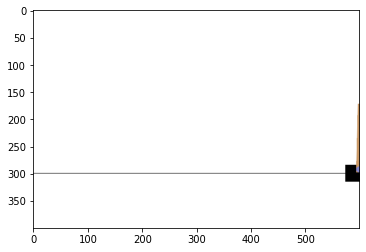

Episode 0 terminated after 318 steps with reward 318.0. 


In [31]:
# This will visualize your learnt policy on the Cart Pole environment
from IPython.display import clear_output


env_render = gym.make("CartPole-v1", render_mode="rgb_array")
for num_episode in range(1):
    s,_ = env_render.reset()
    tot_reward = []
    for t in range(max_episode_len):

        state = torch.tensor(s, dtype=torch.float).view(1, -1)

        prob = a2c.actor(state)
        policy = torch.distributions.categorical.Categorical(prob)
        action = policy.sample()
        s, r, is_terminal, _,_ = env_render.step(action.item())
        tot_reward.append(r)
        if is_terminal:
            print("Episode {} terminated after {} steps with reward {}. ".format(num_episode, t+1, sum(tot_reward)))
            break
        clear_output(wait=True)
        plt.imshow(env_render.render())
        plt.show()

env_render.close()

We use a simple criteria to judge whether you solve the problem.
We will compute an average of the total reward over the previous 100 episodes at each iteration.
If there exists an iteration with average total reward larger than a threshold, as shown below, we will give you full grades.
That is, the problem is solved when the average reward is greater than or equal to 475 over 100 consecutive trials.

Note that `CartPole-v1` has a termination condition of 500 timesteps. It’s done so that one episode doesn’t take forever.
So we say that if a policy can balance a pole for 500 time steps (and achieve 500 reward) it’s probably good enough.

Successfully solve the problem in 422 iterations.


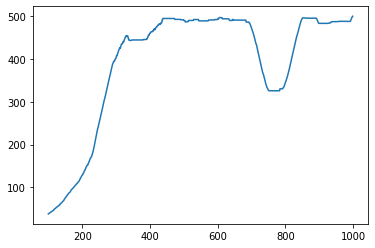

In [37]:
# this code should print success
success_flag = False
buffer_len = 100
buffer_sum = sum(total_reward[:buffer_len])
avg_reward = [buffer_sum / buffer_len]

for num_iter in range(buffer_len, max_iter):
    buffer_sum += total_reward[num_iter]
    buffer_sum -= total_reward[num_iter - buffer_len]
    buffer_avg = buffer_sum / buffer_len
    avg_reward.append(buffer_avg)

    if buffer_avg >= env.spec.reward_threshold and not success_flag:
        print('Successfully solve the problem in {} iterations.'.format(num_iter + 1))
        success_flag = True

if not success_flag:
    print('Unfortunately the agent is not smart enough.')

# plot the average reward curve through the training process
plt.plot(range(buffer_len-1, len(total_reward)), avg_reward)
plt.show()

### Entropy regularized A2C

The exploration-exploition trade-off is also a significant problem to be solved in the context of policy gradients.
There have been numerous approaches in literature aimed towards maximizing exploration in a principled and theoretically meaningful manner.
One such example is the entropy regularised policy gradient objective:
$$
J_\tau(\theta) = J(\theta) + \tau \mathbb{E}_{s \sim d^\pi_s}\left[-\sum_a \pi_\theta(a|s) \log \pi_\theta(a|s)\right],
$$
where $J(\theta)$ is the vanilla policy gradient objective and $\tau$ is a hyperparameter controlling regularisation.

**Task 2.4 (0.5 pt):** Explain why entropy regularization is relevant for encouraging exploration.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

Entropy regularization works by giving a larger value to the right term in the objective function if it has more entropy. The right term has more entropy the more stochastic the policy is. The more deterministic the policy is , the less value the right term will have. If it is fully deterministic, the value $\left[-\sum_a \pi_\theta(a|s) \log \pi_\theta(a|s)\right]$ will be equal to 0 and will have no positive effect on the objective function.


#### Entropy Regularization Example

To understand how entropy regularization works, let's go through a simple mathematical example illustrating its effect on a reinforcement learning policy.

#### Setup

Assume we have an environment where an agent can take two actions: $A_1$ and $A_2$. The agent's policy $\pi_\theta$ is represented as a softmax function of its parameters, which gives probabilities for each action:

$$
\pi_\theta(A_1 | s) = \frac{e^{\theta_1}}{e^{\theta_1} + e^{\theta_2}}, \quad \pi_\theta(A_2 | s) = \frac{e^{\theta_2}}{e^{\theta_1} + e^{\theta_2}}.
$$

#### Example Policies

Let's consider two scenarios with different parameter settings for the policy:

- **Deterministic Policy:**
  - $$ \theta_1 = 5 $$
  - $$ \theta_2 = 0 $$
  - This results in:
    $$
    \pi_\theta(A_1 | s) = 1, \quad \pi_\theta(A_2 | s) = 0
    $$
  - **Entropy:**
    $$
    H(\pi_\theta) = -\left( 1 \cdot \log(1) + 0 \cdot \log(0) \right) = 0
    $$

- **Stochastic Policy:**
  - $$ \theta_1 = 1 $$
  - $$ \theta_2 = 1 $$
  - This results in:
    $$
    \pi_\theta(A_1 | s) = \frac{e^1}{e^1 + e^1} = 0.5, \quad \pi_\theta(A_2 | s) = \frac{e^1}{e^1 + e^1} = 0.5
    $$
  - **Entropy:**
    $$
    H(\pi_\theta) = -\left( 0.5 \cdot \log(0.5) + 0.5 \cdot \log(0.5) \right) = -2 \cdot 0.5 \cdot \log(0.5) = \log(2) \approx 0.693
    $$

#### Objective Function

Suppose we have a simple expected return (reward) function defined as:
$$
J(\theta) = \mathbb{E}_{s \sim d^\pi_s}[R(s)],
$$
where \( R(s) \) is the reward received from state \( s \). Let's assume the expected reward is 10 for our example.

Now, incorporating the entropy term with $\tau = 1$:

- **Deterministic Policy:**
  $$
  J_\tau(\theta) = J(\theta) + \tau H(\pi_\theta) = 10 + 1 \cdot 0 = 10
  $$

- **Stochastic Policy:**
  $$
  J_\tau(\theta) = J(\theta) + \tau H(\pi_\theta) = 10 + 1 \cdot \log(2) \approx 10 + 0.693 = 10.693
  $$

#### Comparison of Policies

The regularized objective $J_\tau(\theta)$ for the stochastic policy is higher than that for the deterministic policy due to the added entropy term. This demonstrates that the stochastic policy, which maintains a higher entropy, is rewarded for its exploration.

#### Implication for Learning

- **Policy Update**: The policy gradient update will favor the stochastic policy because it has a higher objective value. If we apply the policy gradient update:
  $$
  \theta \leftarrow \theta + \alpha \nabla J_\tau(\theta)
  $$
  where $\alpha$ is the learning rate, the update will be more favorable towards the stochastic policy, encouraging the agent to explore more.

- **Exploration**: By including the entropy term in the optimization, the agent is less likely to converge to a suboptimal deterministic policy too early in the training process. Instead, it continues to explore actions, potentially discovering better strategies.

#### Conclusion

This example shows how entropy regularization quantitatively influences the optimization of the policy. The stochastic policy, by maintaining a higher level of exploration (entropy), results in a higher overall objective due to the regularization term, guiding the learning process toward a better exploration-exploitation balance.



**Task 2.5 (1 pt):** Modify the training code from above to demonstrate A2C with entropy regularization. Implement a new loss function that returns your modified loss with entropy regularization. Use entropy regularisation on the CartPole task. Visualize your results and show that you have solved the problem. Compare to your results without entropy regularization in **Task 2.3**.

Also feel free to explore different values of $\tau$ and it's effect on the policy optimization process.

In [38]:
class A2CEntropy():
    def __init__(self, env):
        """Initialization code"""
        # Initiate both nets
        self.actor = ActorNet(env.observation_space.shape[0],
                              env.action_space.n)
        self.critic = CriticNet(env.observation_space.shape[0])

        # Set gamma and learning rates
        self.gamma = 0.99          # Discount factor
        actor_lr = 0.005            # Learning rate for the actor
        critic_lr = 0.005           # Learning rate for the critic
        self.entropy_coef = 0.0001   # Entropy regularization coefficient (tau)

        self.env = env

        # You can also experiment with different optimizers
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    def train(self, max_iter: int = 1000, max_episode_len: int = 500):

        total_reward = []

        pbar = tqdm.tqdm(range(max_iter), desc="Episode")
        for num_iter in pbar:
            # At each iteration, we roll out an episode using current policy
            rewards = []
            log_probs = []
            values = []
            entropies = []

            s, _ = self.env.reset()
            for t in range(max_episode_len):
                # Given current state, get action probabilities from actor
                state = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
                probs = self.actor(state)
                # Create the distribution as current policy
                pi = torch.distributions.Categorical(probs)
                # Sample one action from this policy
                a = pi.sample()

                log_prob = pi.log_prob(a)
                entropy = pi.entropy()

                value = self.critic(state)

                # Interact with the environment
                s_new, r, is_terminal, _, _ = self.env.step(a.item())

                # Store data
                rewards.append(r)
                log_probs.append(log_prob)
                values.append(value)
                entropies.append(entropy)

                s = s_new  # Update state

                if is_terminal:
                    break

            # Store total_reward
            total_reward.append(sum(rewards))

            mean_reward = sum(total_reward[-100:]) / min(len(total_reward), 100)

            # Convert lists to tensors
            log_probs = torch.stack(log_probs)
            values = torch.stack(values).squeeze()
            entropies = torch.stack(entropies)  # Convert entropies to tensor

            # Now compute average entropy
            avg_entropy = entropies.mean().item()

            pbar.set_postfix_str(f"Last reward: {total_reward[-1]}, Avg Entropy: {avg_entropy:.4f}, Mean last 100 episodes: {mean_reward:.2f}")

            # Compute returns and advantages
            returns = []
            R = 0
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            returns = torch.tensor(returns, dtype=torch.float32)

            # Compute advantages
            advantages = returns - values.detach()

            # Compute actor loss (policy gradient with baseline and entropy regularization)
            actor_loss = - (log_probs * advantages).mean() - self.entropy_coef * entropies.mean()

            # Compute critic loss (value function approximation)
            critic_loss = F.mse_loss(values, returns)

            # Update actor network
            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()

            # Update critic network
            self.critic_opt.zero_grad()
            critic_loss.backward()
            self.critic_opt.step()

        self.env.close()

        return total_reward

In [39]:
# TODO: Run your implementation here.
max_iter_entropy = 1000
max_episode_len_entropy = 500

a2c_entropy = A2CEntropy(env)

total_reward_entropy = a2c_entropy.train(max_iter_entropy, max_episode_len_entropy)

Episode: 100%|█| 1000/1000 [06:14<00:00,  2.67it/s, Last reward: 500.0, Avg Entropy: 0.4996, Mean last 100 episodes: 50


Successfully solve the problem in 497 iterations.


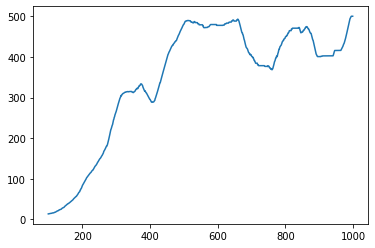

In [40]:
# this code should print success
success_flag = False
buffer_len = 100
buffer_sum = sum(total_reward_entropy[:buffer_len])
avg_reward = [buffer_sum / buffer_len]

for num_iter in range(buffer_len, max_iter):
    buffer_sum += total_reward_entropy[num_iter]
    buffer_sum -= total_reward_entropy[num_iter - buffer_len]
    buffer_avg = buffer_sum / buffer_len
    avg_reward.append(buffer_avg)

    if buffer_avg >= env.spec.reward_threshold and not success_flag:
        print('Successfully solve the problem in {} iterations.'.format(num_iter + 1))
        success_flag = True

if not success_flag:
    print('Unfortunately the agent is not smart enough.')

# plot the average reward curve through the training process
plt.plot(range(buffer_len-1, len(total_reward_entropy)), avg_reward)
plt.show()

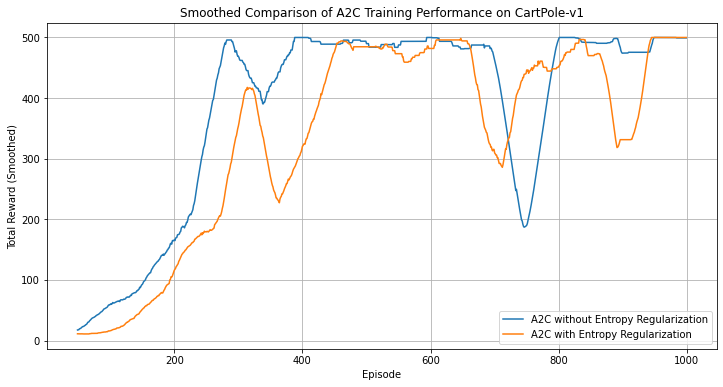

In [41]:
# TODO: Visualize your results and compare it to the results without entropy in Task 2.3
import numpy as np

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Define the window size for the moving average
window_size = 50

# Compute the moving averages
smoothed_total_reward = moving_average(total_reward, window_size)
smoothed_total_reward_entropy = moving_average(total_reward_entropy, window_size)

# Adjust the x-axis to match the length of the smoothed data
episodes = np.arange(window_size - 1, len(total_reward))

# Plotting the smoothed results
plt.figure(figsize=(12, 6))

# Plot smoothed total rewards for the A2C agent without entropy regularization
plt.plot(episodes, smoothed_total_reward, label='A2C without Entropy Regularization')

# Plot smoothed total rewards for the A2C agent with entropy regularization
plt.plot(episodes, smoothed_total_reward_entropy, label='A2C with Entropy Regularization')

# Adding labels and title
plt.xlabel('Episode')
plt.ylabel('Total Reward (Smoothed)')
plt.title('Smoothed Comparison of A2C Training Performance on CartPole-v1')

# Adding legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()
